In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [5]:
def create_filtered_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    syntethic_df.loc[syntethic_df.src_file == synthetic_data_src_files[0], 'real'] = 1
    return syntethic_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [19]:
DEFAULT_FITNESS_FUNCTION_PATH = '../models/cv_fitness_model_2023_01_19.pkl.gz'
with gzip.open(DEFAULT_FITNESS_FUNCTION_PATH, 'rb') as f:
    cv_energy_model = pickle.load(f)

feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]


## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.0025, std: 0.0211, bias: 0.0000


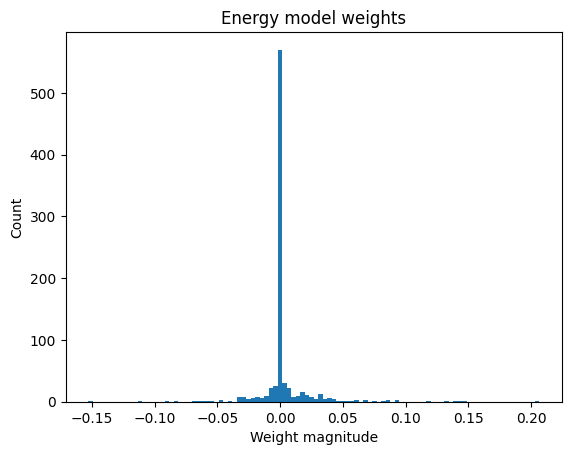

In [27]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=100)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

## Print the top K features most and least predictive of real games

In [57]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games:')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games:')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games:
1. all_variables_used (-0.1531)
2. variable_not_repeated (-0.1102)
3. all_variables_defined (-0.0913)
4. pref_forall_used (-0.0824)
5. arg_types_in_motion_balls (-0.0703)
6. compositionality_structure_1 (-0.0638)
7. arg_types_in_receptacles_balls (-0.0600)
8. no_adjacent_once (-0.0579)
9. arg_types_agent_holds_balls (-0.0536)
10. no_nested_logicals (-0.0478)
11. arg_types_adjacent_agent_room_features (-0.0463)
12. pref_forall_correct_types (-0.0463)
13. compositionality_structure_0 (-0.0401)
14. max_depth_constraints_1 (-0.0343)
15. pref_forall_correct_arity (-0.0338)
16. arg_types_distance_agent_room_features (-0.0334)
17. no_two_number_operations (-0.0332)
18. arg_types_touch_room_features_any_object (-0.0325)
19. compositionality_structure_7 (-0.0318)
20. arg_types_on_furniture_large_objects (-0.0311)
### Features with largest positive weights (most predictive of fake games:
1. arg_types_adjacent_any_object_large_objects (0.2065)
2. arg_types_in_ramps_furniture (0.1460)
3. arg_types_on_ramps_any_object (0.1424)
4. arg_types_on_building_furniture (0.1400)
5. arg_types_touch_colors_ramps (0.1339)
6. arg_types_touch_agent_blocks (0.1192)
7. arg_types_touch_agent_agent (0.0931)
8. arg_types_touch_agent_room_features (0.0924)
9. arg_types_touch_receptacles_room_features (0.0864)
10. arg_types_on_receptacles_small_objects (0.0858)
11. arg_types_touch_ramps_ramps (0.0843)
12. arg_types_on_receptacles_ramps (0.0837)
13. arg_types_on_large_objects_small_objects (0.0750)
14. arg_types_adjacent_balls_agent (0.0698)
15. arg_types_distance_building_agent (0.0678)
16. arg_types_in_receptacles_room_features (0.0623)
17. arg_types_in_motion_room_features (0.0604)
18. arg_types_in_balls_colors (0.0582)
19. arg_types_in_motion_receptacles (0.0535)
20. max_depth_constraints_4 (0.0498)

## Plot a histogram of the values for each of the and bottom K features

In [52]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, histogram_density: bool = True,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        plt.figure(figsize=(4, 4))

        real_values = fitness_df[fitness_df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = fitness_df[fitness_df.real == 0][feature_columns[feature_index]].to_numpy()

        print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        plt.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        plt.xlabel('Feature value')

        if histogram_density:
            plt.ylabel('Density')

        elif histogram_log_y and not histogram_density:
            plt.ylabel('log(Count)')
            plt.semilogy()
        else:
            plt.ylabel('Count')
        
        plt.title(f'Feature #{i + 1}: {columns[feature_index]}\n(weight: {top_k.values[i]:.4f})')
        plt.legend(loc='best')
        plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

Feature = 0 0.00% of the time in real games, 0.51% of the time in synthetic games


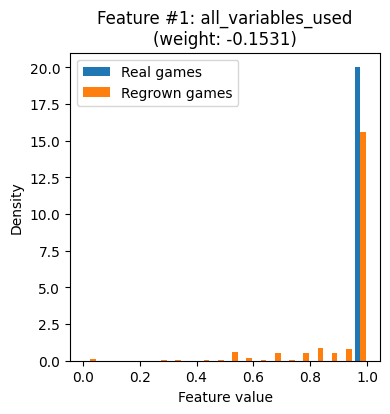

Feature = 0 0.00% of the time in real games, 0.30% of the time in synthetic games


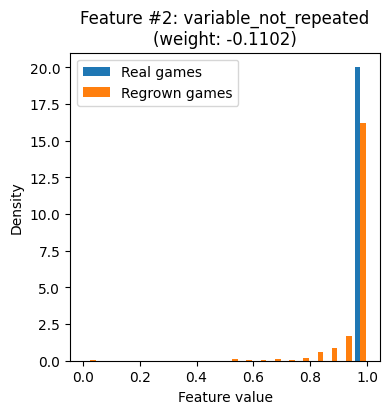

Feature = 0 0.00% of the time in real games, 0.51% of the time in synthetic games


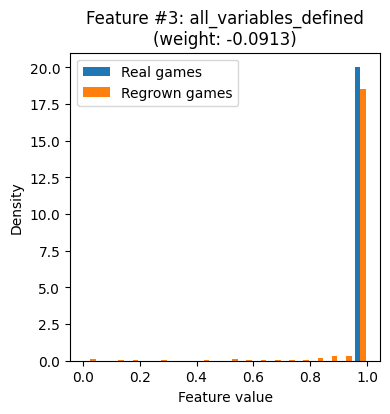

Feature = 0 1.02% of the time in real games, 8.18% of the time in synthetic games


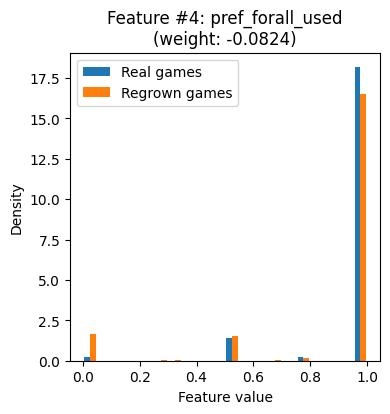

Feature = 0 25.51% of the time in real games, 28.59% of the time in synthetic games


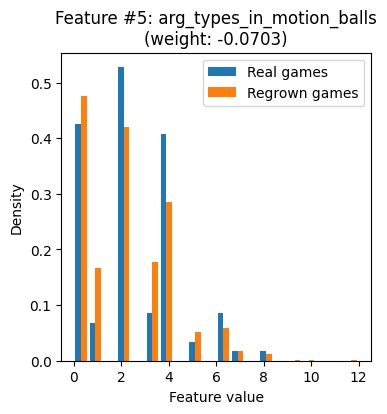

Feature = 0 48.98% of the time in real games, 56.90% of the time in synthetic games


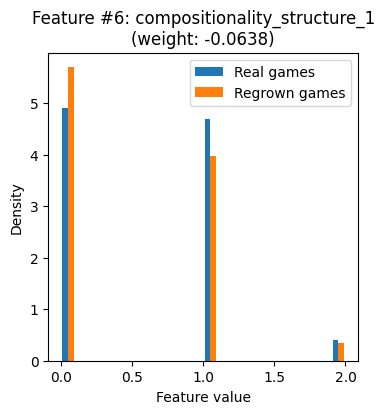

Feature = 0 40.82% of the time in real games, 51.45% of the time in synthetic games


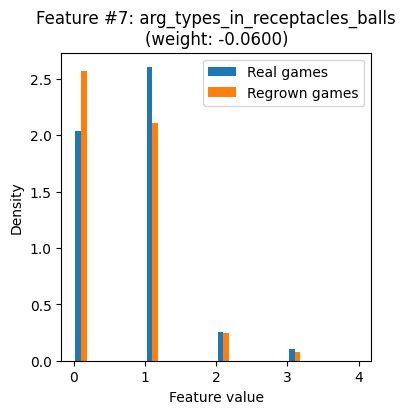

Feature = 0 0.00% of the time in real games, 1.85% of the time in synthetic games


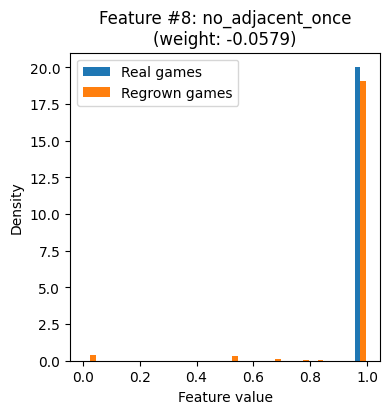

Feature = 0 25.51% of the time in real games, 28.28% of the time in synthetic games


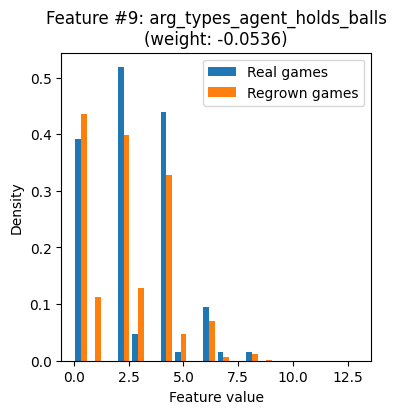

Feature = 0 0.00% of the time in real games, 0.00% of the time in synthetic games


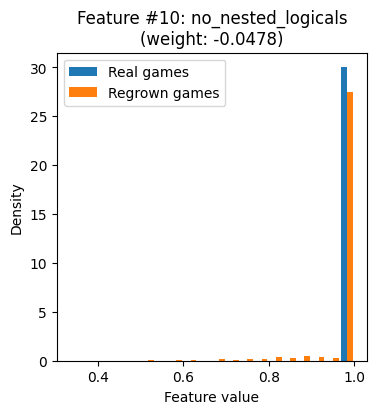

Feature = 0 91.84% of the time in real games, 92.98% of the time in synthetic games


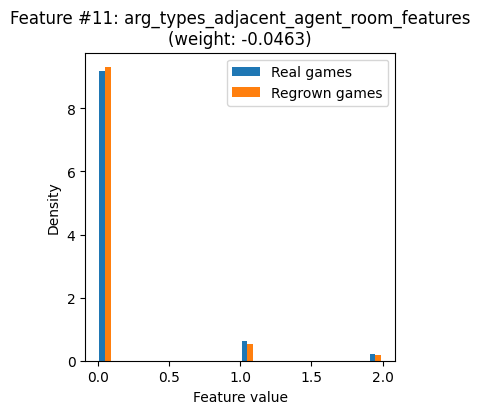

Feature = 0 0.00% of the time in real games, 1.50% of the time in synthetic games


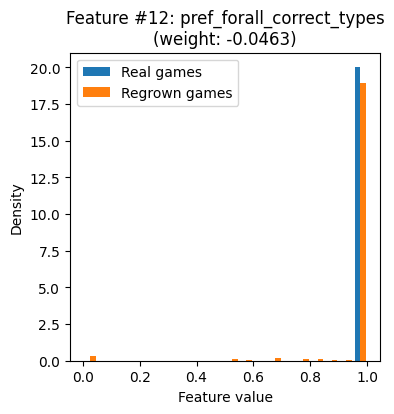

Feature = 0 62.24% of the time in real games, 65.31% of the time in synthetic games


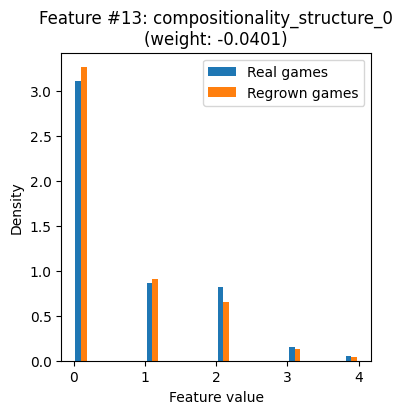

Feature = 0 52.04% of the time in real games, 57.43% of the time in synthetic games


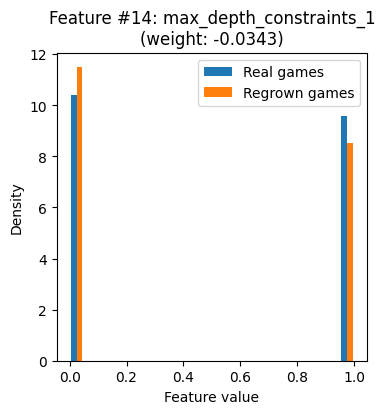

Feature = 0 0.00% of the time in real games, 1.45% of the time in synthetic games


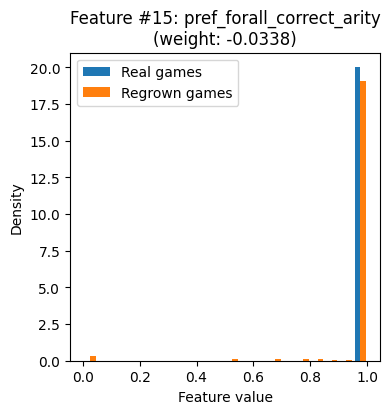

Feature = 0 98.98% of the time in real games, 98.92% of the time in synthetic games


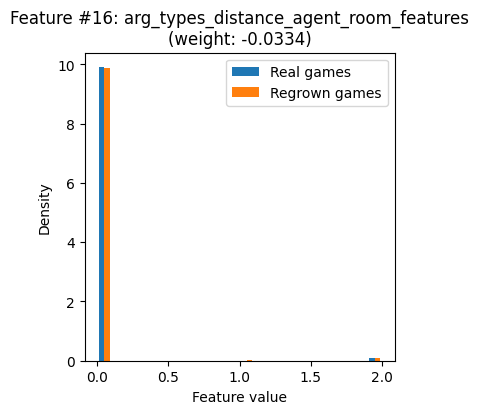

Feature = 0 0.00% of the time in real games, 0.45% of the time in synthetic games


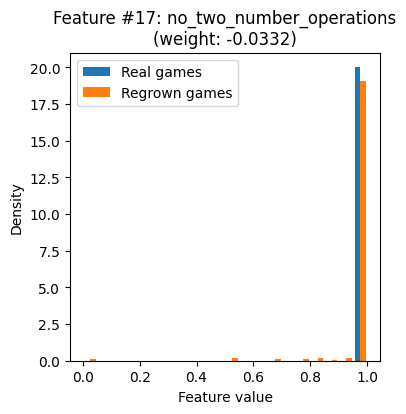

Feature = 0 98.98% of the time in real games, 99.19% of the time in synthetic games


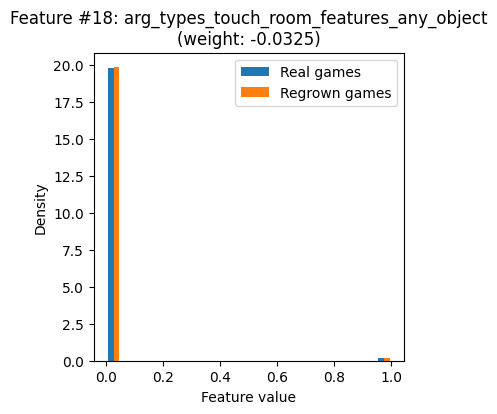

Feature = 0 94.90% of the time in real games, 95.39% of the time in synthetic games


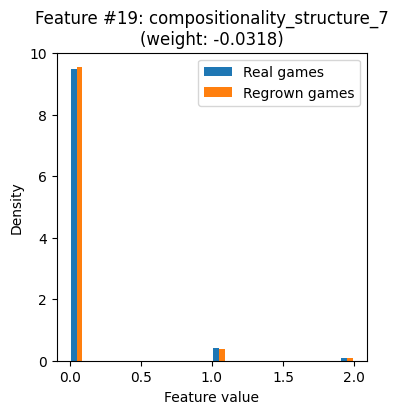

Feature = 0 90.82% of the time in real games, 91.17% of the time in synthetic games


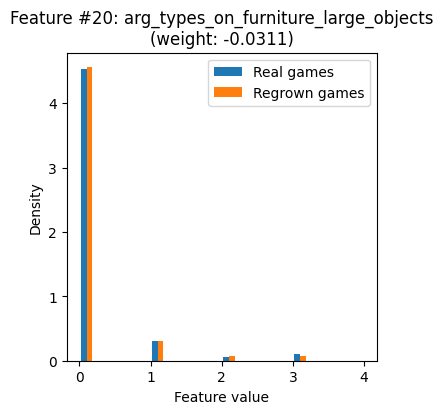

In [53]:
k = 20
plot_value_histograms(filtered_fitness_df, weights, k=k, largest=False, bins=20, histogram_log_y=True)

## For the 10 features with largest weights, that is, most predictive of a fake game

Feature = 0 100.00% of the time in real games, 99.98% of the time in synthetic games


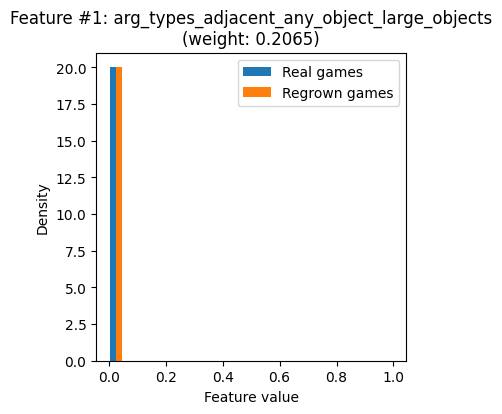

Feature = 0 100.00% of the time in real games, 99.97% of the time in synthetic games


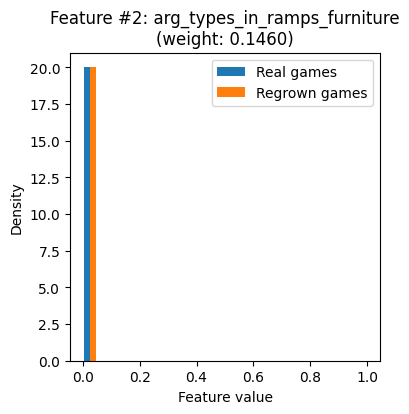

Feature = 0 100.00% of the time in real games, 99.98% of the time in synthetic games


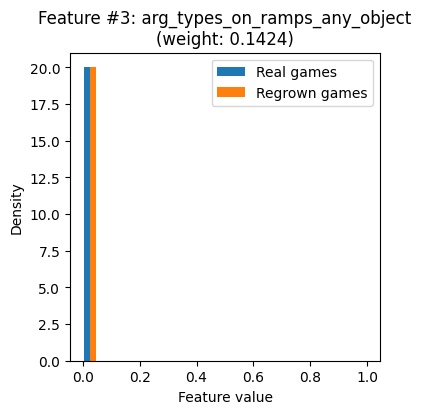

Feature = 0 100.00% of the time in real games, 99.95% of the time in synthetic games


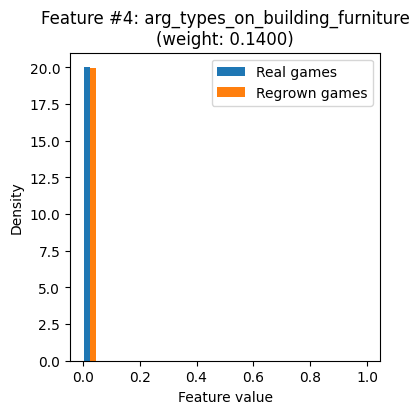

Feature = 0 100.00% of the time in real games, 99.98% of the time in synthetic games


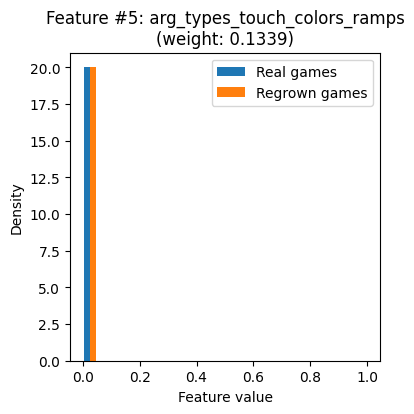

Feature = 0 100.00% of the time in real games, 99.95% of the time in synthetic games


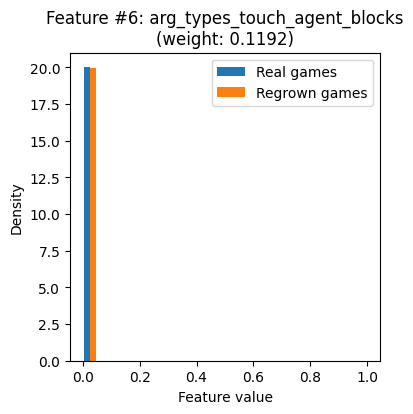

Feature = 0 100.00% of the time in real games, 99.95% of the time in synthetic games


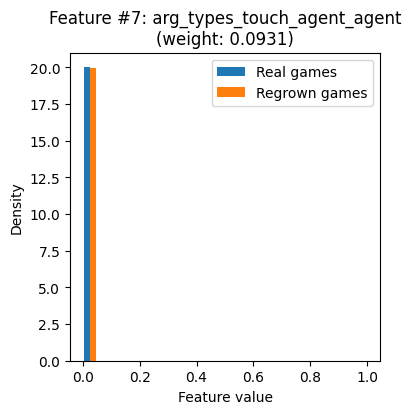

Feature = 0 100.00% of the time in real games, 99.92% of the time in synthetic games


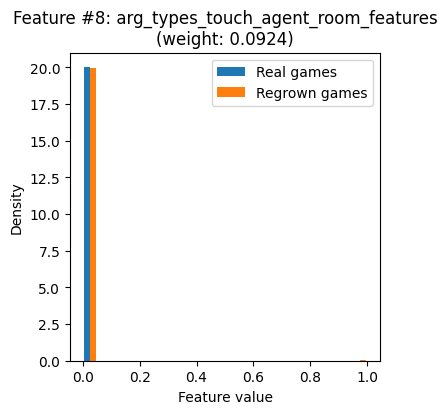

Feature = 0 100.00% of the time in real games, 99.86% of the time in synthetic games


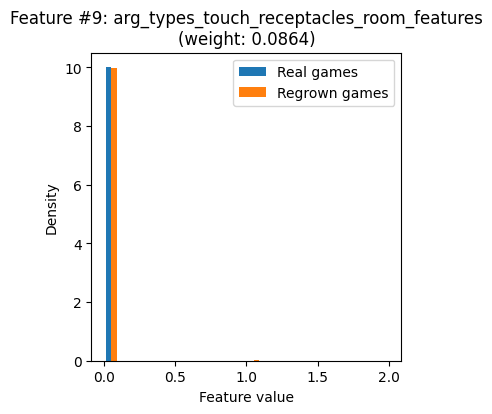

Feature = 0 100.00% of the time in real games, 99.94% of the time in synthetic games


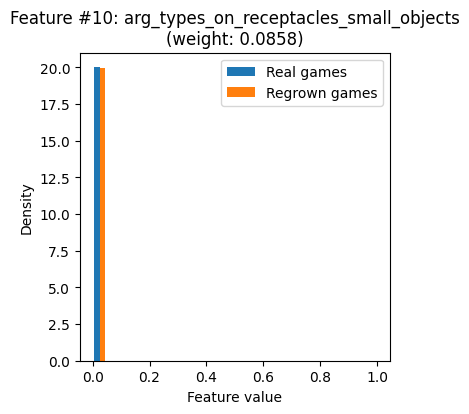

Feature = 0 100.00% of the time in real games, 99.90% of the time in synthetic games


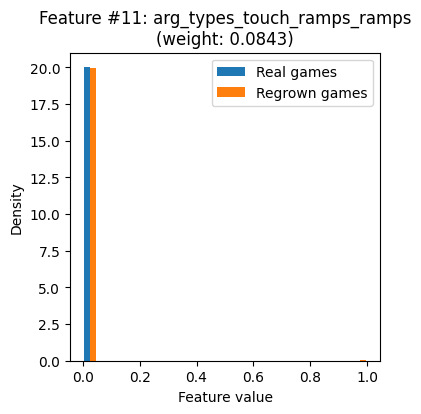

Feature = 0 100.00% of the time in real games, 99.97% of the time in synthetic games


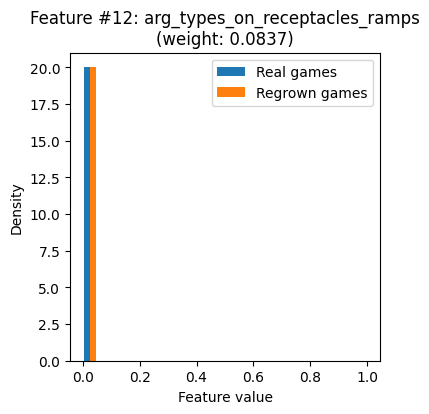

Feature = 0 100.00% of the time in real games, 99.82% of the time in synthetic games


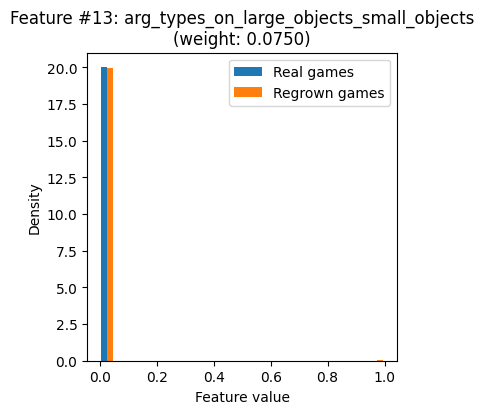

Feature = 0 100.00% of the time in real games, 99.76% of the time in synthetic games


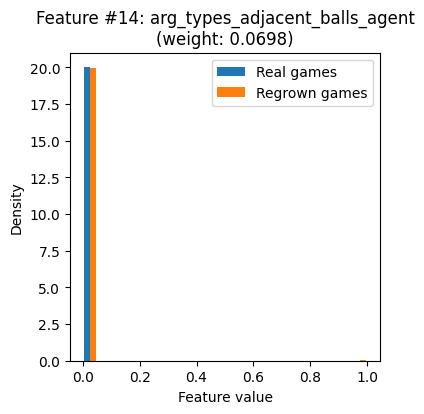

Feature = 0 100.00% of the time in real games, 99.98% of the time in synthetic games


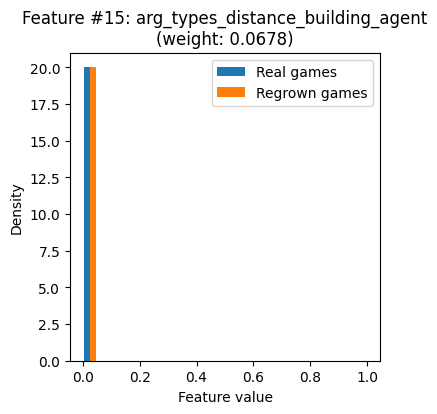

Feature = 0 100.00% of the time in real games, 99.67% of the time in synthetic games


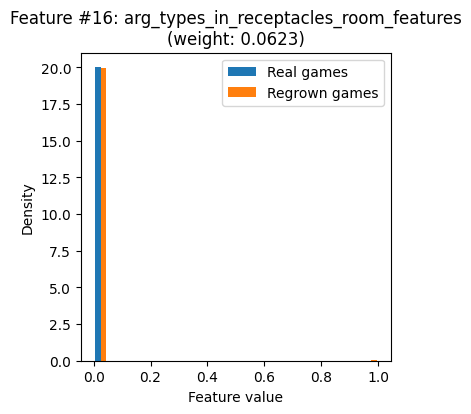

Feature = 0 100.00% of the time in real games, 96.99% of the time in synthetic games


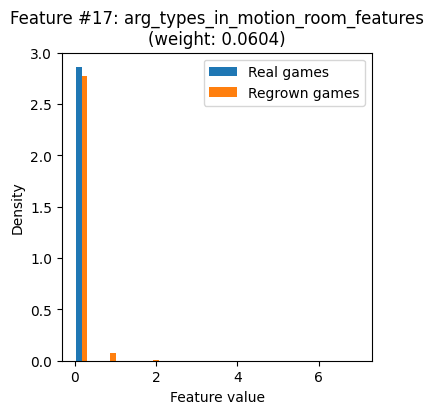

Feature = 0 100.00% of the time in real games, 99.90% of the time in synthetic games


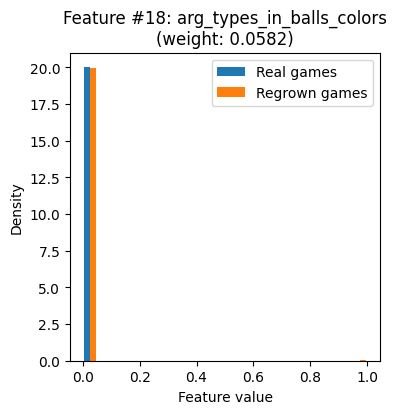

Feature = 0 98.98% of the time in real games, 92.44% of the time in synthetic games


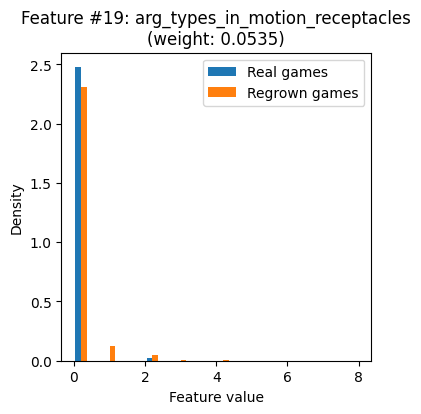

Feature = 0 100.00% of the time in real games, 96.97% of the time in synthetic games


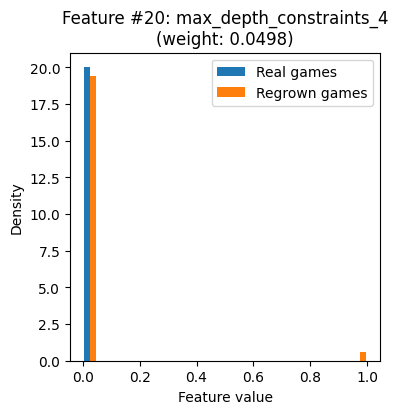

In [54]:
plot_value_histograms(filtered_fitness_df, weights, k=k, largest=True, bins=20, histogram_log_y=True)